# CATRA experiments and analysis

## Preliminaries and parsing
In which we read the log files and interpret the data within.

We start out by implementing a crude parser for the log format CATRA outputs. The first step is to define a result: it's a combination of a runtime, a file that the solver was executed on, and a status. If the status is an error, the runtime is undefined.

In [108]:
from collections import namedtuple
from enum import Enum, auto

class Status(Enum):
    SAT = auto()
    UNSAT = auto()
    TIMEOUT = auto()
    MEMORY_OUT = auto()
    ERROR = auto()

Result = namedtuple("Result", ["backend", "instance", "status", "runtime"])

Then we define routines for parsing input files:

In [109]:
import re

CONFIGS_RE = re.compile(r"\s([^\s]+)")

def status_from_str(status):
    if status == "t":
        return Status.TIMEOUT
    if status == "u":
        return Status.UNSAT
    if status == "s":
        return Status.SAT
    if status == "m":
        return Status.MEMORY_OUT
    if status == "e":
        return Status.ERROR
    
    raise ValueError(f"Unexpected status {status}")

def result_from_str(config_name, instance, res_str):
    status = status_from_str(res_str[0])
    runtime = float(res_str[1:]) if status in [Status.SAT, Status.UNSAT, Status.TIMEOUT] else float("inf")
    return Result(config_name, instance, status, runtime)

def parse_line(line, configurations):
    fields = line.rstrip().split("\t")
    instance = fields[0]
    return [result_from_str(config, instance, res_str) for config, res_str in zip(configurations, fields[1:])]
    
def parse_log(log):
    configurations = []
    with open(log) as fp :
        for line in fp:
            if line.startswith("CONFIGS"):
                configurations = CONFIGS_RE.findall(line)
            if line.startswith("RESULT"):
                for r in parse_line(line[len("RESULT "):], configurations):
                    yield r
                
def find_timeout(log):
    timeout_re = re.compile(r"^==== .*?: timeout > (?P<timeout>.+)ms run: .+s parse: .*====$")

    with open(log) as fp:
        for line in fp:
            match = timeout_re.match(line)
            if not match:
                continue
            runtime = float(match.group("timeout")) / 1_000
            return runtime
    raise ValueError("I found no timeouts in the log file!")

### Common imports

In [110]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)

### Constants

In [151]:
TIMEOUT_S = 120
commit = "0c83096"
machine = "capheus"

## Overhead
In order to know how fair our comparison is, we run all solvers repeatedly on the same, trivial instance.

In [152]:
!cat trivial.par

counter int R1;
synchronised {
  automaton value_0 {
    init s0;
    s0 -> s1 [32, 32] { R1 += 1 };
    accepting s1;
  };
};


In [153]:
%%sh
INVOCATIONS=$(perl -E 'say "trivial.par " x 30')

for backend in lazy nuxmv baseline;
do
  ~/catra/bin/catra solve-satisfy --backend ${backend} $INVOCATIONS > trivial-${backend}.log
done

In [154]:
df = pd.concat(pd.DataFrame(
    parse_log(f"trivial-{backend}.log"))
          .assign(backend = backend) for backend in backends)

NameError: name 'backends' is not defined

Now we can plot the values to see how they look over time. A clear result is that the first run is much slower for all backends, but less so for nuxmv. This is unsurprising, given that the other backends are running on a cold JVM, while nuxmv does most of the work in a compiled binary. We also see here that once the JVM is warm, the overhead for all back-ends normalise to something very similar, with a small, sub .1-second overhead for cold-starting nuxmv for each instance.

In [ ]:
_ = df.groupby("backend")["runtime"].plot(legend=True, 
                                      figsize=(10,6),
                                      xlabel="# iterations", 
                                      ylabel="Runtime (s) logscale",
                                      logy=True,
                                      title="Time spent solving the same trivial instance repeatedly",
                                      style='.')

Filtering out the outliers from the cold runs, we get the following:

In [ ]:
_ = df[df['runtime'] <= 0.1 ].groupby('backend')['runtime'].plot(figsize=(10, 6),
                                      legend=True, 
                                      xlabel="# iterations", 
                                      ylabel="Runtime (s) lin-scale",
                                      style='.',
                                      title="Time spent solving the same trivial instance repeatedly",
                                      logy=False)
plt.tight_layout()

##  Instances solved
How many instances can we solve, in general?

In [ ]:
directory = f"{commit}.{machine}"

In [292]:
runtimes = pd.DataFrame(parse_log("/Users/amanda/catra/37d4e8f.experiments.log"))
runtimes = runtimes[~runtimes.index.duplicated()]
runtimes['backend'] = runtimes['backend'].astype("category")
runtimes['status'] = runtimes['status'].astype("category")
runtimes['status'] = runtimes['status'].cat.set_categories(
    [Status.SAT, Status.UNSAT, Status.TIMEOUT, Status.MEMORY_OUT, Status.ERROR], 
    ordered=True)

#runtimes = runtimes.set_index(['instance', 'backend'])

In [293]:
best_status = runtimes.groupby('instance').status.min()

How many instances for the respective backends?

In [294]:
runtimes.groupby(['backend']).size()

backend
baseline          14750
lazy-norestart    14750
lazy-regular      14750
nuxmv             14750
dtype: int64

In [295]:
NR_INSTANCES = runtimes.instance.unique().size

In [296]:
timeout_instances = best_status[best_status == Status.TIMEOUT].reset_index().instance
#runtimes = runtimes[~runtimes['instance'].isin(timeout_instances)]

How many instances had all solvers time out?

In [297]:
timeout_instances.size

3286

In [298]:
#results_per_instance = runtimes.groupby('instance').size()
#tried_on_all = results_per_instance[results_per_instance == runtimes.backend.cat.categories.size ].reset_index().instance
# runtimes = runtimes[runtimes['instance'].isin(tried_on_all)]

How many instances do we have?

In [299]:
len(runtimes.instance.unique())

14750

How many instances are in each category, per backend?

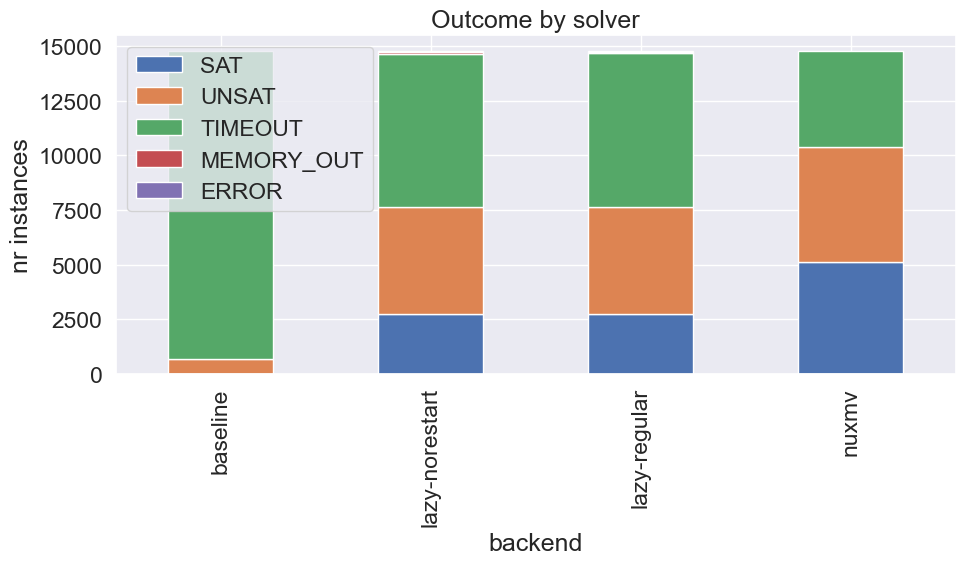

In [300]:
fig, ax = plt.subplots()
runtime_by_status = runtimes.groupby(['backend', 'status']).size().reset_index()
runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
runtime_by_status = runtime_by_status.set_index(['backend', 'status'])
runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title="Outcome by solver", ax=ax)
ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])
plt.tight_layout()
plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

/var/folders/tw/dzvqtdd943z519845l595qbh0000gq/T/ipykernel_85023/3013270416.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nr_solved.groupby('backend').sum().plot.bar(legend=False,


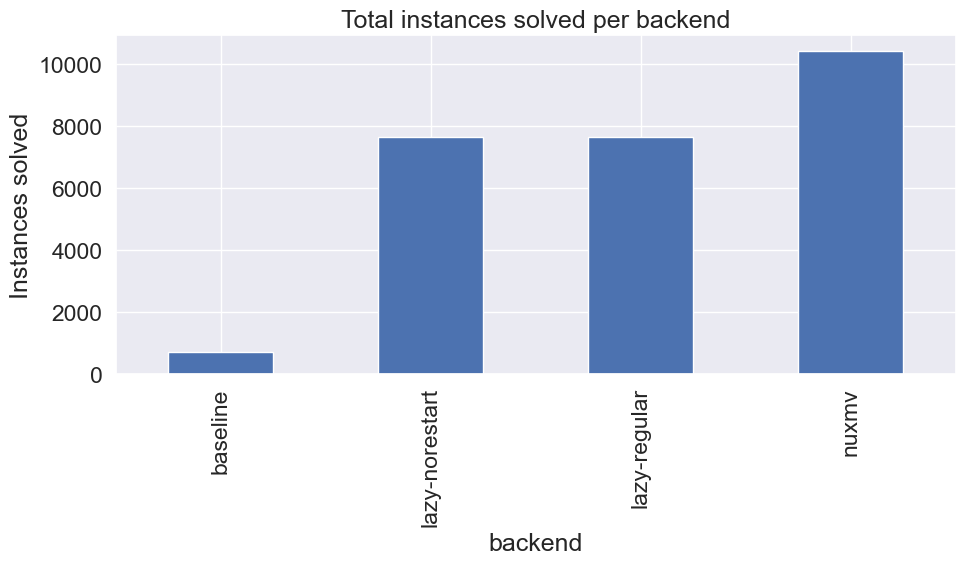

In [301]:
nr_solved = runtimes.groupby(['backend', 'status']).size().reset_index()
nr_solved = nr_solved.loc[nr_solved.status.apply(lambda s: s in [Status.SAT, Status.UNSAT])]
nr_solved.groupby('backend').sum().plot.bar(legend=False,
                                            figsize=(10,6),
                                            ylabel="Instances solved", 
                                            title="Total instances solved per backend")
plt.tight_layout()

How do the respective solvers do on each type of instance?

In [302]:
by_sat_status = pd.DataFrame(runtimes.groupby('instance').status.min())
by_sat_status['instance_kind'] = by_sat_status['status'].astype("category")
by_sat_status['instance_kind'] = by_sat_status.instance_kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = runtimes[runtimes['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='instance')

In [303]:
tbl = pd.pivot_table(known_solved_with_kind, values=['runtime'], 
               index=['instance_kind'], columns=['backend'],
               aggfunc='count')['runtime']
tbl.style.to_latex("solved_pivot_table.tex", hrules=True)
tbl

backend,baseline,lazy-norestart,lazy-regular,nuxmv
instance_kind,,,,
Status.SAT,0,2754,2760,5140
Status.UNSAT,713,4873,4876,5249


## Execution time
For solved instances, for each backend plot the distribution of runtimes

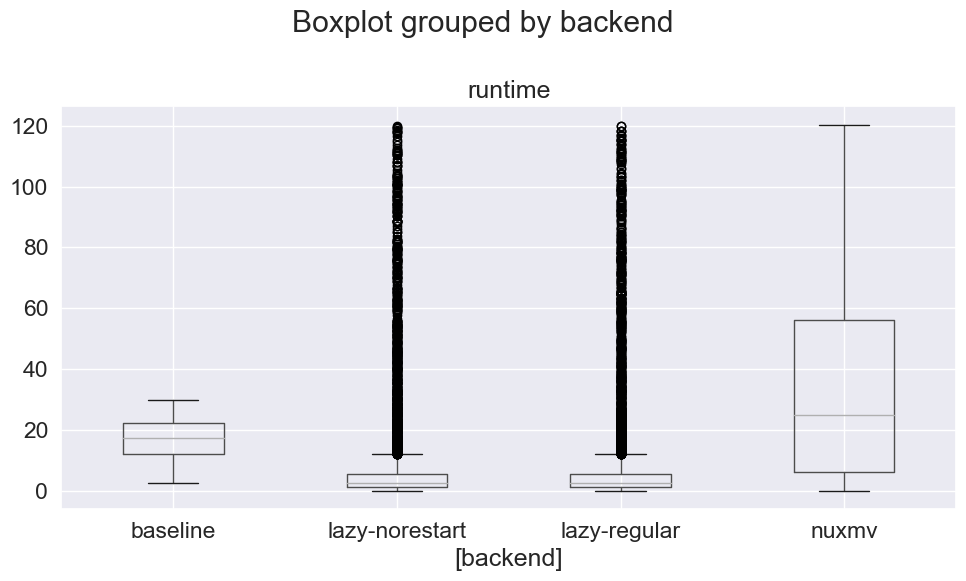

In [304]:
runtimes[runtimes['status'] < Status.TIMEOUT].boxplot(by='backend', figsize=(10,6))
plt.tight_layout()
plt.savefig(f'{commit}-time-boxplot.pdf', dpi=300)

ModuleNotFoundError: No module named 'scipy'

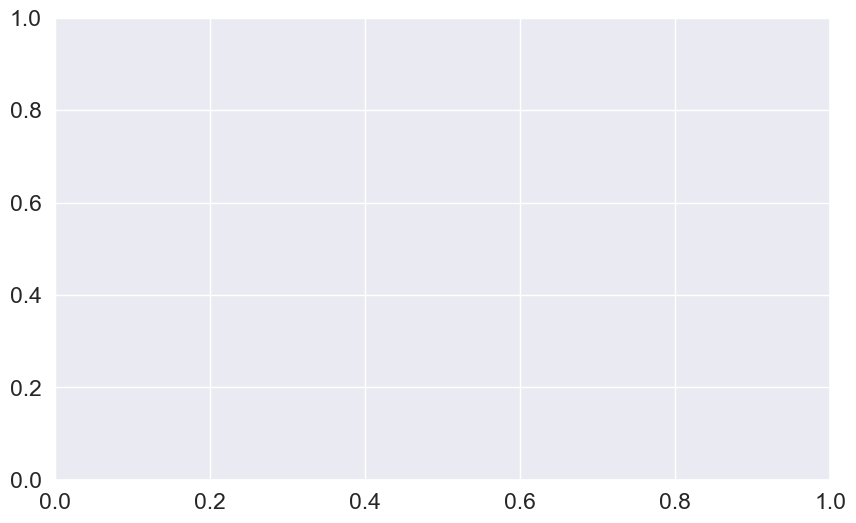

In [305]:
runtimes[runtimes['runtime'] < float('inf')]\
    .set_index('instance')\
    .groupby('backend')\
    .runtime\
    .plot.kde(xlabel='Runtime (s)',
              legend=True,
              figsize=(10, 6),
              title='Distribution of runtimes (s) for solved instances')
plt.tight_layout()

## Scalability (this is the cactus plot section)
If we add more time, how many more instances can we solve?

In [306]:
known_solved = runtimes[runtimes['status'] < Status.TIMEOUT]

def solved_after(seconds, known_solved):
    df = known_solved[known_solved['runtime'] < seconds]\
        .groupby('backend')\
        .size()\
        .reset_index()
    df['after'] = seconds
    df = df.rename(columns = {0: 'nr solved'})
    return df
    
step_size = 1

cactus_data = pd.concat([solved_after(i * step_size, known_solved) for i in range(int(TIMEOUT_S / step_size) + 1)], axis=0)

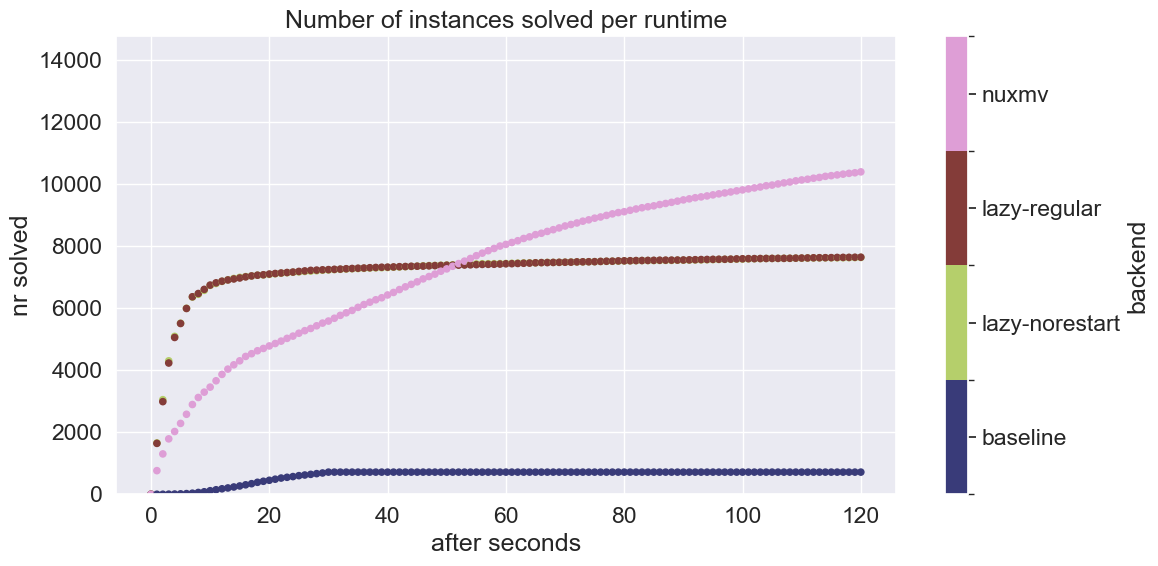

In [307]:
# If we don't use a subplot here, the x ticks and labels all disappear, for no good reason.
fig, ax = plt.subplots()

cactus_data.plot.scatter(x='after', 
                         y='nr solved', 
                         c='backend',
                         xlabel='after seconds',
                         ax=ax,
                         s=20,
                         figsize=(12,6),
                         title="Number of instances solved per runtime",
                         cmap=plt.cm.get_cmap('tab20b'))
fig.tight_layout()
ax.set_ylim(0, NR_INSTANCES)
plt.savefig(f'{commit}-cactus.pdf', dpi=300)

## Duels

This is where we compare pairs of backends. In order to make timeouts plottable we set the runtime of an instance that timed out to the timeout value.

In [ ]:
runtimes_by_backend = known_solved.set_index(['instance', 'backend']).runtime\
    .unstack()\
    .replace(to_replace=float('inf'), value=TIMEOUT_S)
runtimes_by_backend.plot.scatter(x='nuxmv', y='lazy', 
                                 title=f"Lazy vs nuXmv runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1, 
                                 xlabel="nuXmv, runtime (s)")
plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-nuxmv-scatter.pdf', dpi=300)


runtimes_by_backend.plot.scatter(x='baseline', y='lazy', 
                                 title=f"Lazy vs baseline runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1)

plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-baseline-scatter.pdf', dpi=300)

In [ ]:
fig = runtimes_by_backend.boxplot()
fig.set_ylabel("Runtime (s)")
fig.set_title(f"Runtime on solved instances, where timeout = {TIMEOUT_S}s")
plt.tight_layout()

## Finding Parikh Images as Presburger Formulae

## Comparing two versions

In [ ]:
other_commit = "3a993f6"
pretty_name_other = "better-propagation"
compare_backends = ["lazy"]

directory = f"{other_commit}.{machine}"
!cat $directory/backend/lazy/**/stdout > $other_commit-lazy.log
#!cat $directory/backend/baseline/**/stdout > $other_commit-baseline.log
#!cat $directory/backend/nuxmv/**/stdout > $other_commit-nuxmv.log



In [ ]:
comparison_cactus_data = cactus_data.copy()
comparison_cactus_data['backend'] = (comparison_cactus_data['backend'].astype(str) + f"-{commit}").astype('category')

In [ ]:
# Load the data
backend_runtimes = []
for backend in compare_backends:
    df = pd.DataFrame(parse_log(f"{other_commit}-{backend}.log"))
    df = df[df['status'].isin([Status.SAT, Status.UNSAT])] # We only care about solved instances
    df['backend'] = f"{pretty_name_other}-{backend}"
    del df['status']
    df = df.set_index(['instance', 'backend'])
    df = df[~df.index.duplicated()]
    backend_runtimes.append(df.reset_index())
    
runtimes_solved_other = pd.concat(backend_runtimes)

In [ ]:
two_solvers_cactus_data = pd.concat([comparison_cactus_data, 
           *[solved_after(i * step_size, runtimes_solved_other) for i in range(int(TIMEOUT_S / step_size) + 1)]], 
          axis=0)
two_solvers_cactus_data['backend'] = two_solvers_cactus_data['backend'].astype("category")

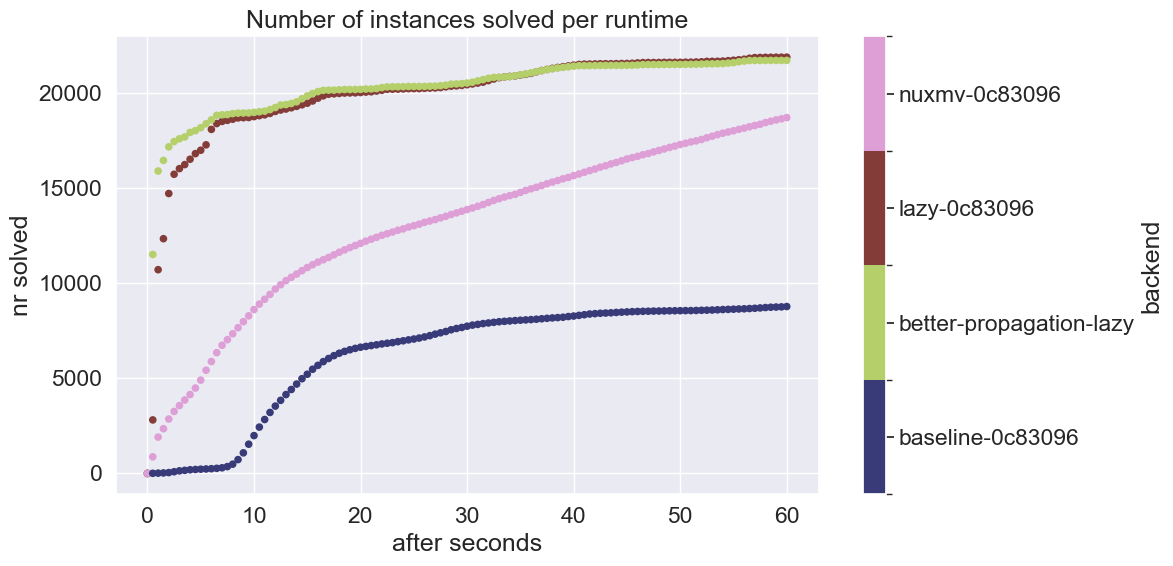

In [95]:
# If we don't use a subplot here, the x ticks and labels all disappear, for no good reason.
fig, ax = plt.subplots()

two_solvers_cactus_data.plot.scatter(x='after', 
                         y='nr solved', 
                         c='backend',
                         xlabel='after seconds',
                         ax=ax,
                         figsize=(12,6),
                         title="Number of instances solved per runtime",
                         cmap=plt.cm.get_cmap('tab20b'))
fig.tight_layout()
#plt.savefig(f'{commit}-cactus.pdf', dpi=300)